In [65]:
import os
os.chdir('/mnt/data/akshit.jain/visual_reco')
import pandas as pd

In [66]:
all_fsn_images=pd.read_csv('tshirt_image_urls.tsv', sep=chr(1), header=None, names=['fsn','url'])

In [165]:
all_fsn_images=pd.concat([all_fsn_images, missing_fsn_images], ignore_index=True)

In [166]:
print("loaded image urls for {} uinque fsns".format(len(all_fsn_images.fsn.unique())))

loaded image urls for 1570060 uinque fsns


In [ ]:
# image url is like:
# https://rukminim1.flixcart.com/image/@widht/@height/jd0jtzk0/t-shirt/g/m/z/s-tblgrvneckd03-tripr-original-imaffzs8pf9r4gfj.jpeg?q=@quality

In [68]:
def get_dynamic_url(static_url):
    static_url="/".join(static_url.split('/')[2:])
    HOST="http://rukminim1.flixcart.com/image"
    return "{0}/@width/@height/{1}?q=@quality".format(HOST, static_url)

# dynamic_url=get_dynamic_url(df.iloc[0].url)
def get_res_image(url, width, height, quality=100, is_static=False):
    if is_static:
        url=get_dynamic_url(url)
    return url.replace('@width', str(width)).replace('@height', str(height)).replace("@quality", str(quality))
# get_res_image(df.iloc[0].url, 100,100, is_static=True)

In [167]:
df=pd.read_pickle('/mnt/data/akshit.jain/user_clicks/data_df.pk')

In [168]:
fsns=pd.Series(df.fsn.unique()).to_frame('fsn')

In [169]:
fsn_image=pd.merge(all_fsn_images, fsns, how='inner', on='fsn')
fsn_image['dynamic_url']=fsn_image.url.apply(get_dynamic_url)

In [170]:
print("filtered and got images for {} fsns out of {}".format(fsn_image.fsn.unique().shape[0], fsns.fsn.unique().shape[0]))

filtered and got images for 23446 fsns out of 23446


In [179]:
fsn_image.to_pickle('tshirt_image_urls_all.pk')

In [100]:
unavail_fsns = frozenset(fsns.fsn) - frozenset(all_fsn_images.fsn)
len(unavail_fsns)
list(set(fsns.fsn.unique()) - set(fsn_image.fsn.unique()))[:10]

In [32]:
fsn_image.head()

,fsn,url,dynamic_url
0,SHTEG8485W9MZHWC,/image/top/s/q/g/161aswthtpnys05-whmt-american...,http://rukminim1.flixcart.com/image/@width/@he...
1,SHTEGDSGFWF5B3BW,/image/jingcy80/bra/a/v/t/32b-sfh045-w-swanij-...,http://rukminim1.flixcart.com/image/@width/@he...
2,SHTEGDSGFWF5B3BW,/image/t-shirt/u/8/n/152orwthntsh42-brwh-ameri...,http://rukminim1.flixcart.com/image/@width/@he...
3,SHTEGE2HNHQVHPYC,/image/jixgfww0/bra/g/v/d/32a-sfh034-bk-swanij...,http://rukminim1.flixcart.com/image/@width/@he...
4,SHTEGE2HNHQVHPYC,/image/j2w6jrk0/kurti/g/6/f/l-wokebobaaa000217...,http://rukminim1.flixcart.com/image/@width/@he...


### Async downlaod shell way

In [54]:
! mkdir product_images

In [173]:
import urllib
import subprocess as sp
import os.path as osp
# max width x height supported on tf hub modules are 224-331 so we will go with 300 for now
IMAGE_DIM=300

data_dir='product_images'

def batch_download(fsns):
    print("downloading batch: {}".format(fsns.name))
    def image_download(fsn, dynamic_url):
        img_uri=get_res_image(dynamic_url, IMAGE_DIM, IMAGE_DIM)# fsn_info['image']['url'].replace('{@width}', str(IMAGE_DIM)).replace('{@height}', str(IMAGE_DIM)).replace('{@quality}', str(100))
        dump_file=osp.join(data_dir,'{}.jpg'.format(fsn))
        if osp.exists(dump_file):
            #print('skipping {}'.format(fsn))
            return
        # todo: download if not exists
        cmd="curl -o {0} '{1}' &".format(dump_file, img_uri)
        sp.call(cmd, shell=True)
    fsns.apply(lambda x: image_download(x.fsn, x.dynamic_url), axis=1)

In [174]:
BATCH_SIZE=100
fsn_image['partition'] = fsn_image.index//BATCH_SIZE
print("total batches: {}".format(fsn_image.partition.unique().shape))
fsn_image.groupby('partition').apply(batch_download)

total batches: (242,)
downloading batch: 0
downloading batch: 0
downloading batch: 1
downloading batch: 2
downloading batch: 3
downloading batch: 4
downloading batch: 5
downloading batch: 6
downloading batch: 7
downloading batch: 8
downloading batch: 9
downloading batch: 10
downloading batch: 11
downloading batch: 12
downloading batch: 13
downloading batch: 14
downloading batch: 15
downloading batch: 16
downloading batch: 17
downloading batch: 18
downloading batch: 19
downloading batch: 20
downloading batch: 21
downloading batch: 22
downloading batch: 23
downloading batch: 24
downloading batch: 25
downloading batch: 26
downloading batch: 27
downloading batch: 28
downloading batch: 29
downloading batch: 30
downloading batch: 31
downloading batch: 32
downloading batch: 33
downloading batch: 34
downloading batch: 35
downloading batch: 36
downloading batch: 37
downloading batch: 38
downloading batch: 39
downloading batch: 40
downloading batch: 41
downloading batch: 42
downloading batch: 43

""


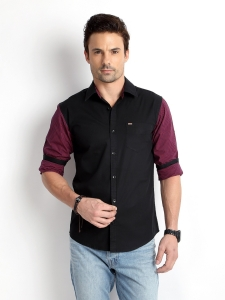

In [175]:
from IPython.display import Image
Image(filename =osp.join(data_dir,'{}.jpg'.format(fsn_image.fsn.iloc[0])))

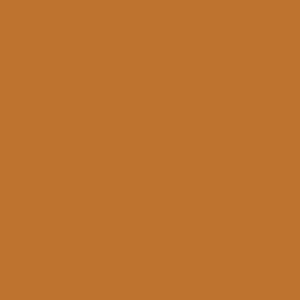

In [176]:
Image(filename =osp.join(data_dir,'{}.jpg'.format('SHTF6NSUR8W5XZPS')))

### Async download pure python way

In [ ]:
import sys
import os
import urllib
import threading
from Queue import Queue

class DownloadThread(threading.Thread):
    def __init__(self, queue, destfolder):
        super(DownloadThread, self).__init__()
        self.queue = queue
        self.destfolder = destfolder
        self.daemon = True

    def run(self):
        while True:
            url = self.queue.get()
            try:
                self.download_url(url)
            except Exception,e:
                print "   Error: %s"%e
            self.queue.task_done()

    def download_url(self, url):
        # change it to a different way if you require
        name = url.split('/')[-1]
        dest = os.path.join(self.destfolder, name)
        print "[%s] Downloading %s -> %s"%(self.ident, url, dest)
        urllib.urlretrieve(url, dest)

def download(urls, destfolder, numthreads=4):
    queue = Queue()
    for url in urls:
        queue.put(url)

    for i in range(numthreads):
        t = DownloadThread(queue, destfolder)
        t.start()

    queue.join()

if __name__ == "__main__":
    download(sys.argv[1:], "/tmp")

## get image urls from api

In [151]:
import requests as R
import json
import itertools

BATCH_SIZE=100

def fetch_from_api(fsns):
    uri="http://10.47.2.116:31100/views/product_base_info?entityIds={}".format(','.join(fsns))
    resp = R.get(uri)
    return resp.json()

def parse_product_info(resp):
    fsn = resp['entityId']
    resp = resp['view']
    image_id = resp['primary_image_id']
    image=[x for x in resp['product_images'] if x['id']==image_id][0]
    return {'fsn':fsn,'url':image['url']}

def parse_response(resp):
    return [parse_product_info(x) for x in resp['entityViews']]

def get_fsns_images(fsn_df):
    print("batch: {}".format(fsn_df.name))
    try:
        fsns = fsn_df.fsn.tolist()
        resp = fetch_from_api(fsns)
        return parse_response(resp)
    except Exception:
        print('failed!!!')
        return []

def batch_and_get_images(fsns):
    fdf=pd.DataFrame(fsns, columns=['fsn'])
    fdf['batch']=fdf.index//BATCH_SIZE
    print("starting fetch for {} batches".format(len(fdf.batch.unique())))
    image_urls = fdf.groupby('batch').apply(get_fsns_images)
    return pd.DataFrame(list(itertools.chain.from_iterable(image_urls.tolist())))


In [153]:
unavail_fsns = list(unavail_fsns)
fsn_images=batch_and_get_images(unavail_fsns)

starting fetch for 123 batches
batch: 0
batch: 0
batch: 1
batch: 2
batch: 3
batch: 4
batch: 5
batch: 6
batch: 7
batch: 8
batch: 9
batch: 10
batch: 11
batch: 12
batch: 13
batch: 14
batch: 15
batch: 16
batch: 17
batch: 18
batch: 19
batch: 20
batch: 21
batch: 22
batch: 23
batch: 24
batch: 25
batch: 26
batch: 27
batch: 28
batch: 29
batch: 30
batch: 31
batch: 32
batch: 33
batch: 34
batch: 35
batch: 36
batch: 37
batch: 38
batch: 39
batch: 40
batch: 41
batch: 42
batch: 43
batch: 44
batch: 45
batch: 46
batch: 47
batch: 48
batch: 49
batch: 50
batch: 51
batch: 52
batch: 53
batch: 54
batch: 55
batch: 56
batch: 57
batch: 58
batch: 59
batch: 60
batch: 61
batch: 62
batch: 63
batch: 64
batch: 65
batch: 66
batch: 67
batch: 68
batch: 69
batch: 70
batch: 71
batch: 72
batch: 73
batch: 74
batch: 75
batch: 76
batch: 77
batch: 78
batch: 79
batch: 80
batch: 81
batch: 82
batch: 83
batch: 84
batch: 85
batch: 86
batch: 87
batch: 88
batch: 89
batch: 90
batch: 91
batch: 92
batch: 93
batch: 94
batch: 95
batch: 96


In [155]:
fsn_images.to_pickle('fsn_images_from_api.pk')

In [160]:
fsn_images['url']=fsn_images.url.apply(lambda x: x.replace('http://img.fkcdn.com',''))

In [162]:
missing_fsn_images=fsn_images

In [156]:
! ls

bpr-model   ctrsr_datasets	ctrsr_datasets.zip	product_images
checkpoint  ctrsr_datasets.rar	fsn_images_from_api.pk	tshirt_image_urls.tsv
